In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
# Import models and metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score , confusion_matrix , precision_score , precision_recall_curve , f1_score
from sklearn.metrics import classification_report , roc_auc_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
import seaborn as sns

In [2]:
users=pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [8]:
engagement.set_index('time_stamp', inplace=True)

In [9]:
engagement.head(10)

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1
2013-12-31 03:45:04,2,1
2014-01-08 03:45:04,2,1
2014-02-03 03:45:04,2,1
2014-02-08 03:45:04,2,1


In [88]:
d2 = pd.read_csv('takehome_user_engagement.csv')
d2['time_stamp'] = pd.to_datetime(d2['time_stamp'])

In [89]:
# Create a function to calculate the rolling 7-day period visit count
def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

d2['visits_7_days'] = d2.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')

In [342]:
d2.head(10)

,time_stamp,user_id,visited,visits_7_days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0
5,2013-12-31 03:45:04,2,1,2.0
6,2014-01-08 03:45:04,2,1,1.0
7,2014-02-03 03:45:04,2,1,1.0
8,2014-02-08 03:45:04,2,1,2.0
9,2014-02-09 03:45:04,2,1,3.0


In [91]:
# Use the rolling frequency counts to extract the unique user_id for the 3 login criteria
adopted = d2[d2.visits_7_days >= 3]
len(adopted)

adopted = adopted.drop_duplicates('user_id', keep = 'first')
adopted_ids = adopted.user_id.tolist()
type(adopted_ids)


list

In [117]:
# Also extract the user_id for 2 logins in 7 days
two_visit = d2[d2.visits_7_days == 2]
two_visit = two_visit.drop_duplicates('user_id', keep = 'first')
two_visit = two_visit[two_visit['user_id'].isin(adopted_ids) == False] 
two_visit_ids = two_visit.user_id.tolist()
len(two_visit_ids)

582

In [119]:
# And also identify user_id with only 1 login in 7 days
one_visit = d2[d2.visits_7_days == 1]
one_visit = one_visit.drop_duplicates('user_id', keep = 'first')
one_visit = one_visit[one_visit['user_id'].isin(adopted_ids) == False] 
one_visit = one_visit[one_visit['user_id'].isin(two_visit_ids) == False] 
one_visit_ids = one_visit.user_id.tolist()
len(one_visit_ids)

6639

In [113]:
d2.visits_7_days.value_counts()

7.0    47183
4.0    29276
5.0    28884
3.0    27754
6.0    27425
2.0    23954
1.0    23441
Name: visits_7_days, dtype: int64

In [121]:
# Add the adopted (3 or more visits), 2 visit, and 1 visit columnd to the user table
users['adopted'] = users.object_id.isin(adopted_ids)
users['two_visit'] = users.object_id.isin(two_visit_ids)
users['one_visit'] = users.object_id.isin(one_visit_ids)
users.adopted.sum()


1602

In [343]:
users.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_yn,two_visit,one_visit,creation_age,login_session_yn,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1970-01-01 00:00:01.398138810,1,0,11,10803.0,0,1,0,1,691,1,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1970-01-01 00:00:01.396237504,0,0,1,316.0,1,1,0,0,533,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1970-01-01 00:00:01.363734892,0,0,94,1525.0,0,1,0,1,292,1,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1970-01-01 00:00:01.369210168,0,0,1,5151.0,0,1,0,1,355,1,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1970-01-01 00:00:01.358849660,0,0,193,5240.0,0,1,0,1,231,1,1,0,0,0,0


## Examine the user data by looking at the categorical "creation_source" distribution for the login categories. Note that the zero login case can be observed as the null values in "last_session_creation_time". It appears that the distribution is about the same whether the user categorized as adopted, two, or one login in 7-days but "sign_up_google_auth" completely disappears for the no-login case. In other words, users from this source always log in at least once.

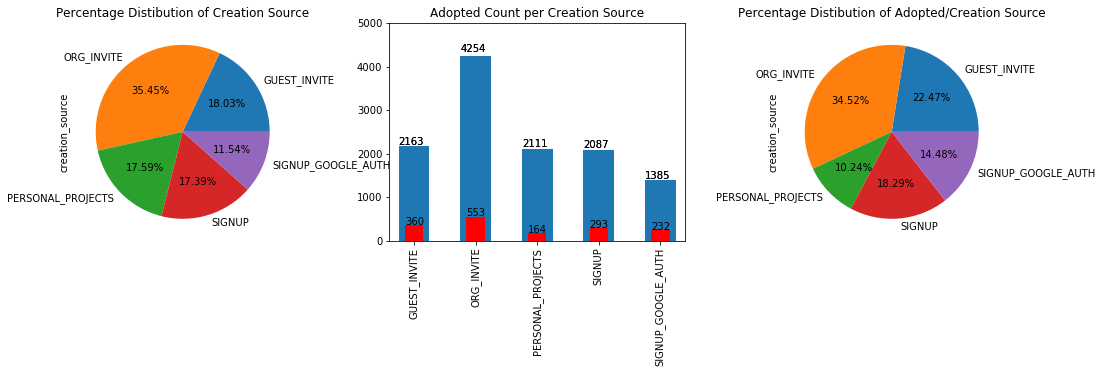

In [134]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("Adopted Count per Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)
users[(users['adopted'] == True)].creation_source.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)

ax3.set_title("Percentage Distibution of Adopted/Creation Source")
users[(users['adopted'] == True)].creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()

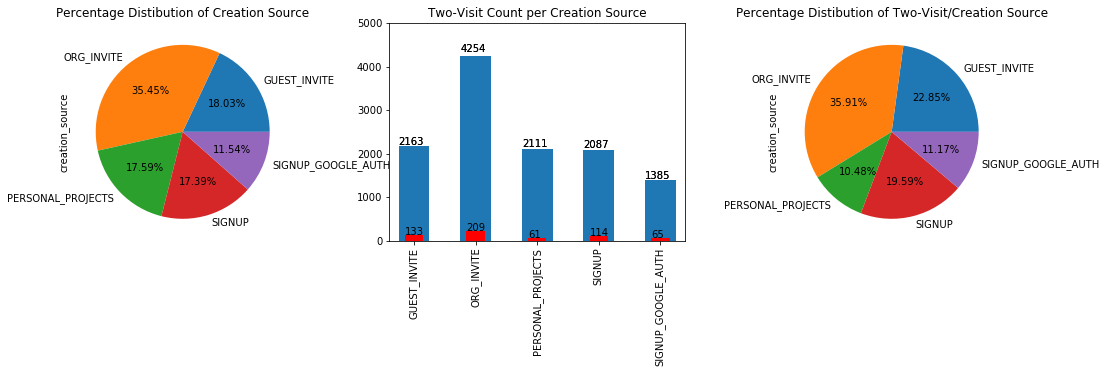

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("Two-Visit Count per Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)
users[(users['two_visit'] == True)].creation_source.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)

ax3.set_title("Percentage Distibution of Two-Visit/Creation Source")
users[(users['two_visit'] == True)].creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()

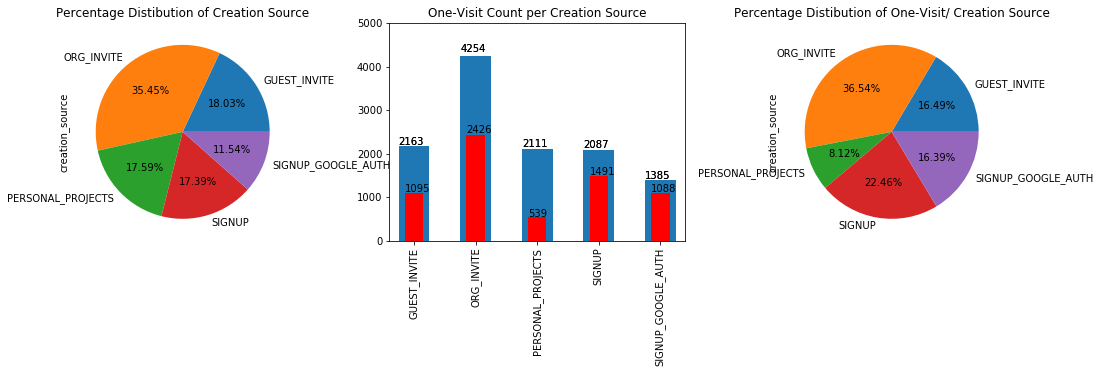

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("One-Visit Count per Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)
users[(users['one_visit'] == True)].creation_source.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)

ax3.set_title("Percentage Distibution of One-Visit/ Creation Source")
users[(users['one_visit'] == True)].creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()

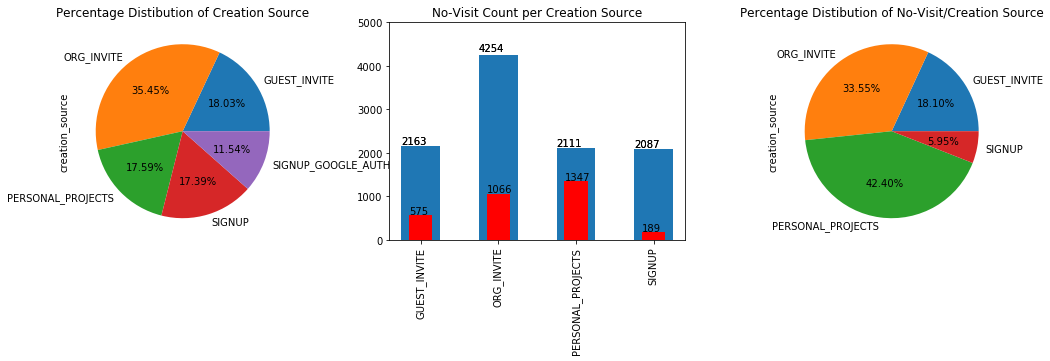

In [137]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("No-Visit Count per Creation Source")
users.creation_source.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)
users[(users['last_session_creation_time'].isnull())].creation_source.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,5000)

ax3.set_title("Percentage Distibution of No-Visit/Creation Source")
users[(users['last_session_creation_time'].isnull())].creation_source.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()

## The boolean features also show a pattern of keeping the same distribution despite the login count category. Each comparison is shown for the Adopted users, and the remaining 2, 1, and 0 login users_id's are shown for the "Invites" category. These results imply that it is difficult to spot patterns in the data provided.

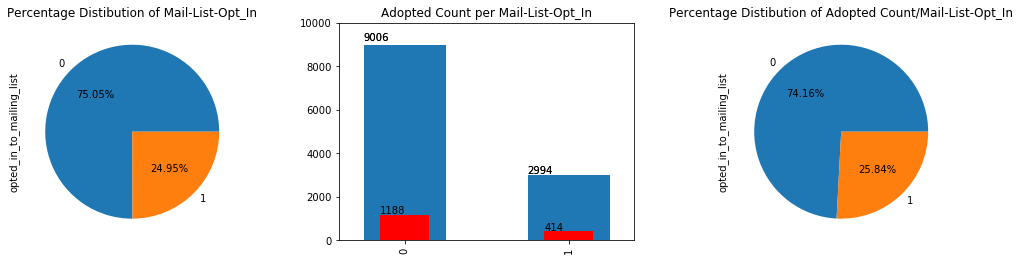

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Mail-List-Opt_In")
users.opted_in_to_mailing_list.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("Adopted Count per Mail-List-Opt_In")
users.opted_in_to_mailing_list.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,10000)
users[(users['adopted'] == True)].opted_in_to_mailing_list.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,10000)

ax3.set_title("Percentage Distibution of Adopted Count/Mail-List-Opt_In")
users[(users['adopted'] == True)].opted_in_to_mailing_list.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()

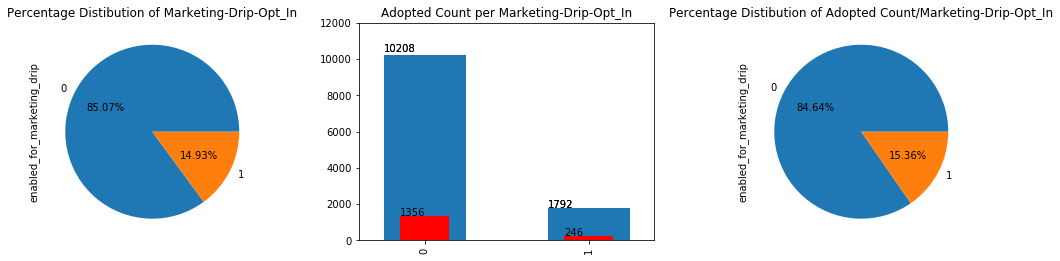

In [131]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Marketing-Drip-Opt_In")
users.enabled_for_marketing_drip.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("Adopted Count per Marketing-Drip-Opt_In")
users.enabled_for_marketing_drip.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)
users[(users['adopted'] == True)].enabled_for_marketing_drip.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)

ax3.set_title("Percentage Distibution of Adopted Count/Marketing-Drip-Opt_In")
users[(users['adopted'] == True)].enabled_for_marketing_drip.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()


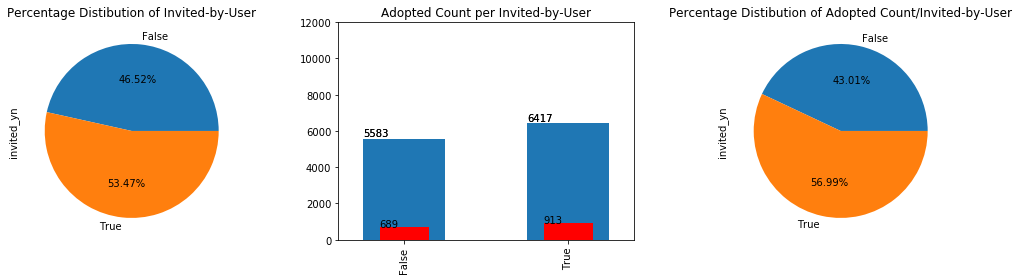

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Invited-by-User")
users.invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("Adopted Count per Invited-by-User")
users.invited_yn.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)
users[(users['adopted'] == True)].invited_yn.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)

ax3.set_title("Percentage Distibution of Adopted Count/Invited-by-User")
users[(users['adopted'] == True)].invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()


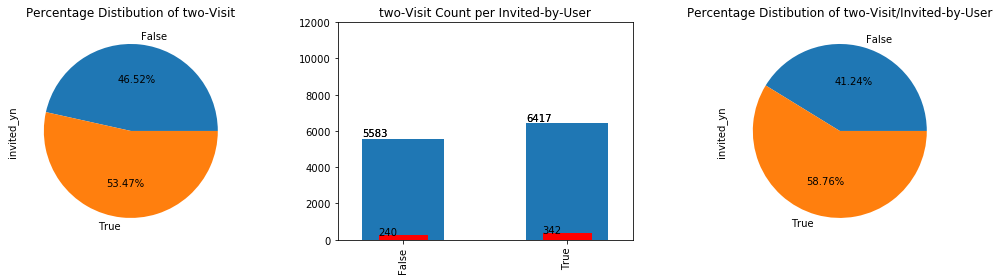

In [139]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of two-Visit")
users.invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("two-Visit Count per Invited-by-User")
users.invited_yn.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)
users[(users['two_visit'] == True)].invited_yn.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)

ax3.set_title("Percentage Distibution of two-Visit/Invited-by-User")
users[(users['two_visit'] == True)].invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()


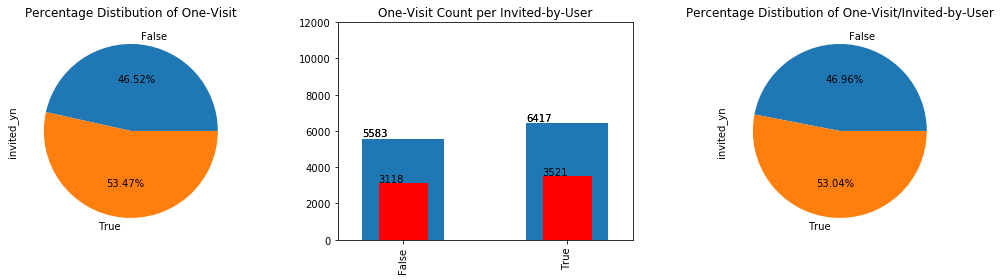

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of One-Visit")
users.invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("One-Visit Count per Invited-by-User")
users.invited_yn.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)
users[(users['one_visit'] == True)].invited_yn.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)

ax3.set_title("Percentage Distibution of One-Visit/Invited-by-User")
users[(users['one_visit'] == True)].invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()


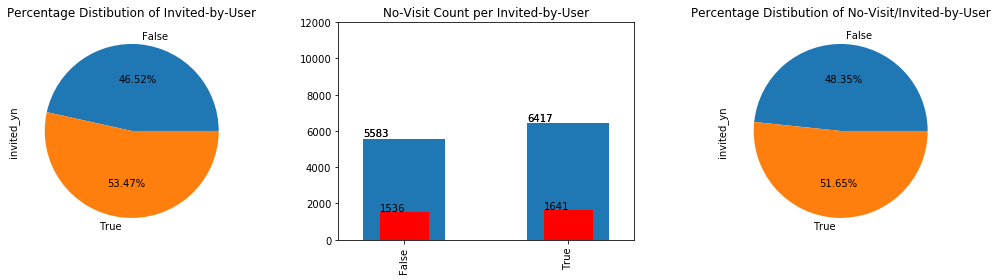

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax1.set_title("Percentage Distibution of Invited-by-User")
users.invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax1)

ax2.set_title("No-Visit Count per Invited-by-User")
users.invited_yn.value_counts().sort_index().plot(kind='bar', ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)
users[(users['last_session_creation_time'].isnull())].invited_yn.value_counts().sort_index().plot(kind='bar', width=0.3, color='r',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))
    ax2.set_ylim(0,12000)

ax3.set_title("Percentage Distibution of No-Visit/Invited-by-User")
users[(users['last_session_creation_time'].isnull())].invited_yn.value_counts().sort_index().plot(kind='pie', autopct='%.2f%%', ax=ax3)


plt.tight_layout
plt.show()


# Select and build feautures for the Binary Classification model, to predict adopted users.

In [86]:
# Convert creation_time to an integer representing days since the earliest date in the dataset
users.creation_time = pd.to_datetime(users.creation_time)
users['creation_age'] = users['creation_time'] - min(users['creation_time'])
users['creation_age'] = users['creation_age'].dt.days.astype('int64')


In [162]:
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time) 

In [175]:
# Convert last_session_create_time to a boolean integer represwnting whether user ever logged in
users['login_session_yn'] = users['last_session_creation_time'].isnull() == False
users.login_session_yn = users.login_session_yn.astype(int)
users.login_session_yn.value_counts()

1    8823
0    3177
Name: login_session_yn, dtype: int64

In [176]:
# Convert categorical creation_source features to boolean integers
users = pd.get_dummies(users, columns=['creation_source'])

In [198]:
# Convert booleans to integer
users.adopted = users.adopted.astype(int)
users.invited_yn = users.invited_yn.astype(int)
users.two_visit = users.two_visit.astype(int)
users.one_visit = users.one_visit.astype(int)

In [330]:
users2 = users.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
                     'invited_by_user_id', 'org_id', 'login_session_yn'], axis=1)

In [331]:
users2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
adopted                               12000 non-null int32
invited_yn                            12000 non-null int32
two_visit                             12000 non-null int32
one_visit                             12000 non-null int32
creation_age                          12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: int32(4), int64(3), uint8(5)
memory usage: 527.5 KB


# The Randon Forest Classifier was chosen, and is an ensemble model that is known to work well for binary classification. Train, test, split and Cross Validation are emploted, as well as centering and normalizing with Standard Scaler. A model pipeline is employed in order to illustate some parameter tuning. Train vs Test results are shown in order to check for overfitting in relation to parameter and feature selection.

In [332]:
# Define X with selected columns, y as the binary variable to predict
# Drop the unnecessary and wronf format columns
X = users2.drop(['adopted'], axis = 1).values
y = users2['adopted'].values

In [333]:
# Train, Test, Split to segregate Training from Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [335]:
%%time
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators=10))
         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#param_grid = {'rfc__max_depth': [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30]}
param_grid = {'rfc__max_depth': [None]}
#param_grid = {'rfc__max_depth': [100, 500]}


#param_grid = {'rfc__max_depth': [30],
#                'rfc__class_weight': [None],
#                 'rfc__criterion' : ['entropy']}


# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned RFC Parameter: {}".format(rfc.best_params_))
print("Tuned RFC Accuracy: {}".format(rfc.best_score_))


# Compute and print metrics
print (confusion_matrix(y_test , rfc_predict))
print ("Accuracy score: ", accuracy_score(y_test , rfc_predict))
print("F1 score: ", f1_score(y_test , rfc_predict))
print("Precision score: " , precision_score(y_test , rfc_predict))
print("Recall score: " , recall_score(y_test , rfc_predict))
print (classification_report(y_test , rfc_predict))
rfc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Tuned RFC Parameter: {'rfc__max_depth': None}
Tuned RFC Accuracy: 0.8664444444444445
[[2437  156]
 [ 218  189]]
Accuracy score:  0.8753333333333333
F1 score:  0.5026595744680852
Precision score:  0.5478260869565217
Recall score:  0.4643734643734644
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2593
           1       0.55      0.46      0.50       407

    accuracy                           0.88      3000
   macro avg       0.73      0.70      0.72      3000
weighted avg       0.87      0.88      0.87      3000

Wall time: 319 ms


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                  

## The max_depth hyperparameter was tuned automatically by GridSearchCV, and improved the model performance compared using 8 instead of the defult value "None". The train vs test visualizaton justifies the optimization with the observation that the training result diverges from the test, or starts overfitting as a higher max_depth values.


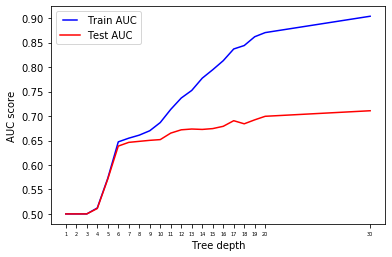

Wall time: 10.5 s


In [336]:
%%time
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30]
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)}, fontsize=10)
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30], fontsize=5)
plt.show()

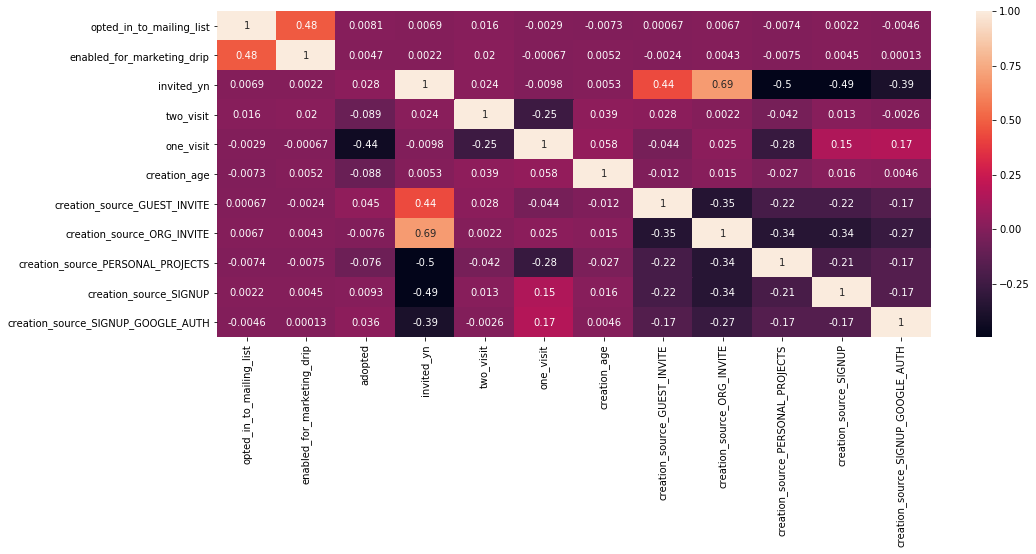

In [337]:
ax = plt.subplots(figsize=(16,6)) 
corrMatrix = users2.corr().drop(['adopted'])
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [338]:
df_cols = users2[:0]
df_cols = users2.drop(['adopted'], axis = 1 )
for item1,item2 in sorted(zip(rfc.best_estimator_.named_steps['rfc'].feature_importances_,df_cols.columns),reverse=True):
    print(f'{item2} has a score of {item1}')

creation_age has a score of 0.5552393531948712
one_visit has a score of 0.28713551571393714
two_visit has a score of 0.055266926252213744
creation_source_SIGNUP_GOOGLE_AUTH has a score of 0.039632180036719644
creation_source_PERSONAL_PROJECTS has a score of 0.026972644006891512
creation_source_SIGNUP has a score of 0.014625763120823861
invited_yn has a score of 0.00633225444100345
opted_in_to_mailing_list has a score of 0.00577160074029505
enabled_for_marketing_drip has a score of 0.005031067300341318
creation_source_GUEST_INVITE has a score of 0.002373738890285364
creation_source_ORG_INVITE has a score of 0.0016189563026178342


## The correlation matrix above shows most features are not correlated except the "invited" feature constructed from the same data. The creation-age feature dominates, but the 1 and 2 visit features make sense for the model, as observed by running with the top features excluded. Note the synthetic boolean feature that indicates whether a user_id has never logged in caused the model to overfit such that the results are almost 100% accurate. The view shown above makes the most sense given the tradesoffs between accuracy and overfitting. Rather than pick a specific metric succh as Precision, F1, ROC, the confusion matrix is also shown in order to quicly visualize the amont of False Positives and False Negatives. The overall model performance is in the range of 86% Accuracy but 50% Precison, F1 ad ROC. It does appear that the "Signup_Google_Auth" feature has some significance as predicted by the Exploratory Data Analysis.  

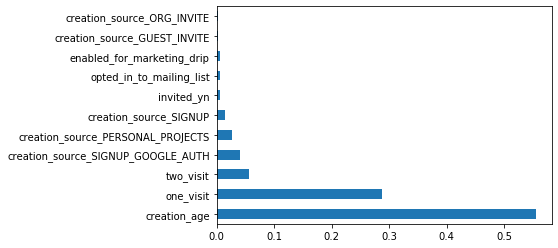

In [345]:
feat_importances = pd.Series(rfc.best_estimator_.named_steps['rfc'].feature_importances_, index=df_cols.columns)
feat_importances.nlargest(18).plot(kind='barh')

In [347]:
users3 = users.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
                     'invited_by_user_id', 'org_id'], axis=1)
X = users3.drop(['adopted'], axis = 1).values
y = users3['adopted'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [348]:
%%time
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators=10))
         ]

pipeline = Pipeline(steps)

# Create the hyperparameter grid
#param_grid = {'rfc__max_depth': [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30]}
param_grid = {'rfc__max_depth': [None]}
#param_grid = {'rfc__max_depth': [100, 500]}


#param_grid = {'rfc__max_depth': [30],
#                'rfc__class_weight': [None],
#                 'rfc__criterion' : ['entropy']}


# Instantiate the GridSearchCV object: logreg_cv
rfc = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit it to the training data
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

# Print the optimal parameters and best score
print("Tuned RFC Parameter: {}".format(rfc.best_params_))
print("Tuned RFC Accuracy: {}".format(rfc.best_score_))


# Compute and print metrics
print (confusion_matrix(y_test , rfc_predict))
print ("Accuracy score: ", accuracy_score(y_test , rfc_predict))
print("F1 score: ", f1_score(y_test , rfc_predict))
print("Precision score: " , precision_score(y_test , rfc_predict))
print("Recall score: " , recall_score(y_test , rfc_predict))
print (classification_report(y_test , rfc_predict))
rfc

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Tuned RFC Parameter: {'rfc__max_depth': None}
Tuned RFC Accuracy: 1.0
[[2593    0]
 [   0  407]]
Accuracy score:  1.0
F1 score:  1.0
Precision score:  1.0
Recall score:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2593
           1       1.00      1.00      1.00       407

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Wall time: 3.01 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                  

# Note the extreme result of nearly 100% predictability when including the boolean "Never Logged In" feature. 

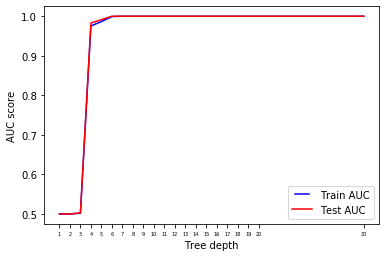

Wall time: 10.1 s


In [352]:
%%time
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30]
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)}, fontsize=10)
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30], fontsize=5)
plt.show()

one_visit has a score of 0.42047882042223234
login_session_yn has a score of 0.37312649324880637
two_visit has a score of 0.14566270435970025
creation_age has a score of 0.024418257539941056
creation_source_SIGNUP_GOOGLE_AUTH has a score of 0.019687208937433205
creation_source_SIGNUP has a score of 0.008716159331210753
creation_source_PERSONAL_PROJECTS has a score of 0.002266765561528162
creation_source_GUEST_INVITE has a score of 0.0018875843210992027
enabled_for_marketing_drip has a score of 0.001408584789787586
opted_in_to_mailing_list has a score of 0.001073556499304208
creation_source_ORG_INVITE has a score of 0.0010037354548446005
invited_yn has a score of 0.0002701295341123758


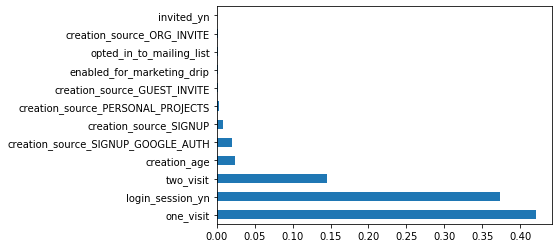

In [351]:
df_cols = users3[:0]
df_cols = users3.drop(['adopted'], axis = 1 )
for item1,item2 in sorted(zip(rfc.best_estimator_.named_steps['rfc'].feature_importances_,df_cols.columns),reverse=True):
    print(f'{item2} has a score of {item1}')
feat_importances = pd.Series(rfc.best_estimator_.named_steps['rfc'].feature_importances_, index=df_cols.columns)
feat_importances.nlargest(18).plot(kind='barh')